<h1 style="border:1px solid white; padding:5px; text-align:center; ">Analyse des revenus sur le territoire de GPSEA en 2019</h1>

<h2 style="border:1px solid green;">Objectifs</h2>
<ul>
    <li>Faire une analyse de l'autocorrélation spatiale globale</li>
    <li>Calculer l'autocorrélation spatiale locale</li>
</ul>

<h2 style="border:1px solid green;">Préparation des données</h2>

In [1]:
import pandas 

## revenus en 2019 France entière
revenus19 = pandas.read_csv(".\\DONNEES\\BASE_TD_FILO_DISP_IRIS_2019.csv", sep=";", decimal=".",
    dtype={"IRIS":str}, encoding="utf-8")

revenus19 = revenus19[ ["IRIS", "DISP_MED19"] ]

revenus19.head()

,IRIS,DISP_MED19
0,10040101,19400
1,10040102,17490
2,10040201,19670
3,10040202,24310
4,10330102,20050


In [2]:
## Ensuite, on va récupérer les IRIS :
import geopandas
## Couche des communes de GPSEA
gpsea_com = geopandas.read_file(".\\DONNEES\\contours_gpsea.geojson", geometry="geometry",
                                dtype={"code_insee_commune":str}, encoding="latin1")

## La donnée est issue du catalogue de données du Grand Paris Sud Est Avenir 
gpsea_com = gpsea_com[ ["nom_de_la_commune", "code_insee_commune", "population", "geometry"] ]
## respectivement : nom de la commune, code INSEE de la commune, taille de la population, géometrie de la commune
gpsea_com.head()

gpsea_com.crs ## 4326

gpsea_com["code_insee_commune"] = gpsea_com["code_insee_commune"].astype(str)
gpsea_com.dtypes

nom_de_la_commune       object
code_insee_commune      object
population               int64
geometry              geometry
dtype: object

In [3]:
## Couche des IRIS France entière
iris_gpsea = geopandas.read_file(".\\DONNEES\\IRIS_GE.SHP", geometry="geometry",
                                 dtype={"INSEE_COM":str, "CODE_IRIS":str})

## conserver uniquement les IRIS de GPSEA
iris_gpsea = iris_gpsea[ iris_gpsea["INSEE_COM"].isin(list(gpsea_com.code_insee_commune.unique())) ]

iris_gpsea = iris_gpsea.to_crs(4326) ## on rappel que Folium supporte uniquement les données en 4326
iris_gpsea.head()

,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS,geometry
16,94002,Alfortville,0203,940020203,Carnot Petit Pont Alouettes,H,"POLYGON ((2.41733 48.78073, 2.41803 48.78174, ..."
22,94028,Créteil,0305,940280305,Plaisance-Les Tilleuls,H,"POLYGON ((2.45363 48.79915, 2.45390 48.79927, ..."
27,94011,Bonneuil-sur-Marne,0105,940110105,Saint-Exupéry,H,"POLYGON ((2.48039 48.77052, 2.48065 48.77062, ..."
30,94044,Limeil-Brévannes,0107,940440107,Les Grands Champs,H,"POLYGON ((2.48916 48.75858, 2.48963 48.75872, ..."
35,94047,Mandres-les-Roses,0000,940470000,Mandres-les-Roses,Z,"POLYGON ((2.52681 48.70506, 2.52688 48.70510, ..."


In [4]:
revenus19 = revenus19[ revenus19["IRIS"].isin( list(iris_gpsea.CODE_IRIS.unique()) ) ]
revenus19.head()

revenus19.isna().sum()

IRIS          0
DISP_MED19    0
dtype: int64

<h2 id="geoviz" style="border:1px solid green;">Géovisualisation</h2>

In [5]:
# Graphics
import matplotlib.pyplot as plt
import seaborn

# Analysis
from numpy.random import seed

In [6]:
## joindre les données revenus dans les IRIS:

db = pandas.merge(left=iris_gpsea, right=revenus19, left_on="CODE_IRIS", right_on="IRIS", how="left")

db.drop(columns=["IRIS_y", "IRIS_x", "TYP_IRIS"], inplace=True)
db.head()

## S'assurer que les données sont en unité métrique :
db.crs 
db = db.to_crs(3857)

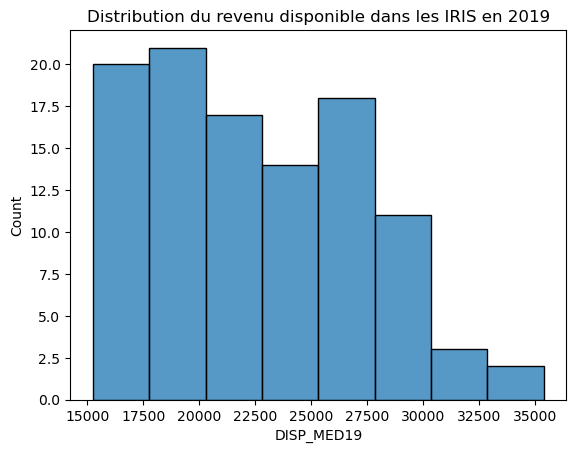

In [7]:
seaborn.histplot(x="DISP_MED19", data=db)
plt.title("Distribution du revenu disponible dans les IRIS en 2019")
plt.show()

SystemError: initialization of _internal failed without raising an exception

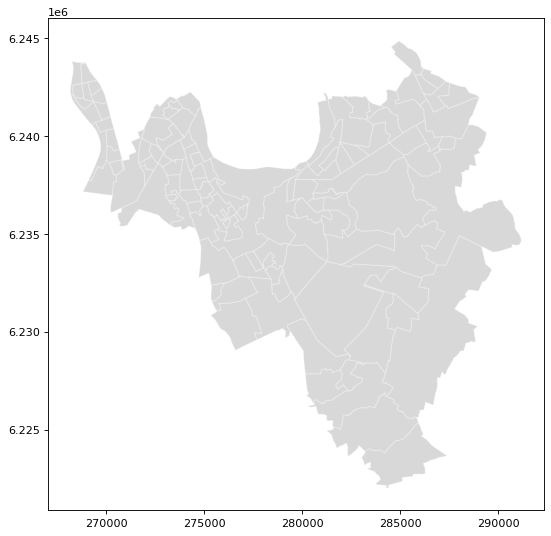

In [8]:
## on a une distribution fortement asymétrique
## on peut alors utiliser la méthode des quantiles :

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

iris_gpsea = iris_gpsea.to_crs(epsg=3857)

iris_gpsea.plot(
    color="grey",
    edgecolor="white",
    alpha=0.3,
    legend=True,
    ax=ax
)

## db["DISP_MED19"].fillna(value=0, inplace=True)
db.plot(
    column="DISP_MED19",
    scheme="quantiles",
    cmap="viridis",
    edgecolor="white",
    k=5,
    alpha=0.75,
    legend=True,
    ax=ax
)

plt.title("Distribution des revenus sur le territoire", fontsize=20)
ax.set_axis_off()
plt.show()

<p style="border:2px solid red; padding:5px;"><span style="font-weight:bold;">Interprétation : </span>Les IRIS grisés sont les IRIS pour lesquelles aucune donnée n'est fourni en 2019. Cela peut être dû au secret statistique, ou encore que la commune ne continent pas assez d'habitant pour former un IRIS mais est alors considérée comme une commune. Par exemple, l'IRIS grisé de Bonneuil-sur-Marne correspond au Port de Bonneuil, qui contient principalement des zones d'emploi. En raison de la distribution, nous avons réalisé une discrétisation en quantile. On peut voir que Créteil possède des IRIS très différents. D'autre part, on remarque comme un "gradient" entre l'Ouest et l'Est.</p>

<h2 id="spatial_analysis" style="border:1px solid green;">Analyse spatiale</h2>

In [ ]:
## charger les bibliothèques d'analyse spatiale :
# Graphics
import pysal
from pysal.viz import splot
from splot.esda import plot_moran

# Analysis
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

Ensuite nous allons calculer le poids spatial, pour un voisinage de 5.

In [ ]:
## générer les poids depuis le df :
w = weights.KNN.from_dataframe(db, k=8)
## standardiser es résultats :
# w.transform = "R"